## Forecasts for Product Demand
### Background
- https://www.kaggle.com/datasets/felixzhao/productdemandforecasting?resource=download
- The dataset contains historical product demand for a manufacturing company with footprints globally. 
- The company provides thousands of products within dozens of product categories. 
- There are four central warehouses to ship products within the region it is responsible for. 
- Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. 
- If forecasts for each product in different central with reasonable accuracy for the **monthly demand for month after next** can be achieved, it would be beneficial to the company in multiple ways.

## Steps

- Perform EDA
- Build a machine learning model predicting order counts for the next month by the warehouse
- Evaluate the performance of the model

In [1]:
import logging
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import shap
from sklearn.metrics import r2_score
#import check_numeric

sns.set_style('darkgrid')
sns.set_palette("bright")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
file_name = "data/Historical Product Demand.csv"        
start_date = '2012-01-01'
end_date = '2016-12-31'

## Class Info.

- 예측 구분 및 타깃: 센터별 D+1의 주문수
- 예측 방법: 모든 과거 데이터는 누적하며, 최신 타깃값을 이용해 모델에 학습
    - 학습셋: 2012-01-01~ (약 4년)
    - 테스트셋: 2016-11-01~2016-12-30 (약 2개월)
    - 알고리즘: LGBM 등 앙상블
- 지표: MdAPE (Median Absolute Percentage Error)


In [12]:
## todo: 딥러닝, 앙상블 등
## todo: SQL

In [14]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

In [112]:
class OrderPredictByCenter():

    """
    하루씩 stride, 최신 데이터를 계속 학습하면서 다음날 주문수에 대해 예측수행하는 클래스
    1) 추출 및 전처리
    2) 피처 엔지니어링: 샘플 데이터이므로 실무상황 대비 풍부하지 못함
    3) 학습 및 예측수행
    """
    
    def __init__(self):

        self.file_path = "data/Historical Product Demand.csv"
        self.start_date = '2012-01-01'
        self.end_date = '2016-12-31'
        self.shap_cut_date = '2016-12-01'
        self.label_encoder = LabelEncoder()
        self.target_encoder = ce.TargetEncoder(cols=['warehouse'])        
        self.base_model = LGBMRegressor()
        self.use_vote_regressor = False
        self.opt_param = False # True 경우 파라메터 최적화 진행
        self.param_space = {
                            'learning_rate': np.logspace(-3, 0, num=100),
                            'n_estimators': np.arange(50, 300, step=10),
                            'max_depth': np.arange(3, 11),
                            'num_leaves': np.arange(10, 101),
                            'min_child_samples': np.arange(5, 31)
                            } 
                
    @staticmethod
    def _check_if_numeric(value):
        """
        값이 만약 수치형이면 True, 아니면 에러대신 False 반환
        """
        try:
            pd.to_numeric(value)
            return True
        except (TypeError, ValueError):
            return False


    def load_data(self):

        """
        데이터 불러와서 타깃의 값이 수치형 아닌 경우 제거
        """
        df = pd.read_csv(self.file_path) # local path
        df.columns = ['prd_code', 'warehouse', 'category', 'date', 'order']

        # 수치형이 아닌 경우 제거
        df['is_num'] = df.order.apply(self._check_if_numeric)
        df = df.query("is_num == True").drop('is_num', axis=1)

        # datetime, int 형태로 컬럼 타입을 변환
        df['date'] = pd.to_datetime(df['date'])
        df.rename(columns={'date':'target_date'}, inplace=True)        
        df['order'] = df['order'].astype(int)    
        
        # 비정상 데이터 제거
        df = df.query("target_date >= @self.start_date and target_date <= @self.end_date")
        
        # 센터별로 집계
        df = df.groupby(["warehouse", "target_date"])['order'].sum().reset_index()                
        return df 
    
    
    def add_date_features(self, df):
        
        """
        날짜 관련 피처엔지니어링
        """
        df['month'] = df['target_date'].dt.month
        df['day'] = df['target_date'].dt.dayofweek
        df['dayofweek'] = df['target_date'].dt.day_name()
        df["weekend_yn"] = np.where(df["dayofweek"].isin(["Saturday", "Sunday"]), 1, 0)  # 주말여부
        df["dayofyear"] = df['target_date'].dt.dayofyear  # 연간 일                
        df["week_no"] = df['target_date'].dt.isocalendar()['week'].astype('int')
        df['week_num'] = np.ceil((df['target_date'].dt.to_period('M').dt.to_timestamp().dt.weekday + df['target_date'].dt.day) / 7.0).astype(int)  # 월별주차
        df = pd.concat([df, pd.get_dummies(data=df['dayofweek'], prefix='dayofweek')], axis=1)  # 요일 one-hot encoding

        # 월별 누적주문수
        # monthly prediction을 위해 YYYY-MM 형태로 변환
        df['date_month'] = pd.to_datetime(df['target_date'].dt.strftime('%Y-%m'))        
        df['ord_cnt_cum'] = df.groupby(['date_month', 'warehouse'])['order'].cumsum()        
        return df
    
    
    def add_fe_laggging(self, df, max_lagging_n=30):

        """
        lagging 피처 및 rolling mean 피처 추가
        """
        # 이전 동요일 주문수 피처
        for n in np.arange(1, max_lagging_n):
            df[f'ord_cnt_d{n}'] = df.groupby(['warehouse', 'dayofweek'])['order'].shift(n)
            
        for n in np.arange(1, max_lagging_n):
            df[f'ord_cnt_cum_d{n}'] = df.groupby(['warehouse', 'dayofweek'])['ord_cnt_cum'].shift(n)            
            df[f'ord_cnt_roll_d{n}'] = df.groupby(['warehouse', 'dayofweek'])['ord_cnt_d1'].transform(lambda x: x.rolling(n,1).mean())
            df[f'ord_cnt_ewm_d{n}'] = df.groupby(['warehouse', 'dayofweek'])['ord_cnt_d1'].transform(lambda x: x.ewm(span=n, adjust=False).mean())

        return df         
      
    
    def add_fe_change_ratio(self, df):
        
        """
        주차별 변동율을 피처로 활용
        """
        df[f'ord_cnt_change_d1'] = (df[f'ord_cnt_d1']-df[f'ord_cnt_d2'])/df[f'ord_cnt_d2']
        df[f'ord_cnt_change_d2'] = (df[f'ord_cnt_d2']-df[f'ord_cnt_d3'])/df[f'ord_cnt_d3']
        df[f'ord_cnt_change_d4'] = (df[f'ord_cnt_d4']-df[f'ord_cnt_d5'])/df[f'ord_cnt_d6']
        df[f'ord_cnt_change_d6'] = (df[f'ord_cnt_d6']-df[f'ord_cnt_d7'])/df[f'ord_cnt_d7']
        df[f'ord_cnt_change_d14'] = (df[f'ord_cnt_d14']-df[f'ord_cnt_d7'])/df[f'ord_cnt_d7']

        df[f'ord_cnt_change_d1'] = (df[f'ord_cnt_cum_d1']-df[f'ord_cnt_cum_d2'])/df[f'ord_cnt_cum_d2']
        df[f'ord_cnt_change_d2'] = (df[f'ord_cnt_cum_d2']-df[f'ord_cnt_cum_d3'])/df[f'ord_cnt_cum_d3']
        df[f'ord_cnt_change_d4'] = (df[f'ord_cnt_cum_d4']-df[f'ord_cnt_cum_d5'])/df[f'ord_cnt_cum_d5']
        df[f'ord_cnt_change_d6'] = (df[f'ord_cnt_cum_d6']-df[f'ord_cnt_cum_d7'])/df[f'ord_cnt_cum_d6']
        df[f'ord_cnt_change_d14'] = (df[f'ord_cnt_cum_d14']-df[f'ord_cnt_cum_d7'])/df[f'ord_cnt_cum_d6']
        
        return df
     
    
    def add_fe_ord_ratio(self, df, max_lagging_n=8):
        """
        센터별 월별 일별 비중을 lagging
        """
        df['ord_sum_cnt'] = df.groupby(['warehouse','date_month'])['order'].transform(sum) # todo: delete
        df['ord_ratio_day'] = df['order']/df['ord_cnt_cum'] # todo: delete
        
        for n in np.arange(1, max_lagging_n):
            df[f'ord_ratio_w{n}'] = df.groupby(['warehouse', 'dayofweek'])['ord_ratio_day'].shift(n)
        
        return df
     
        
    def fit_predict(self, df):
        
        """
        특정일 기준으로 데이터셋 구분후 인코딩
        """
        # index target_date로 지정
        if 'target_date' in df.columns:
            df = df.set_index("target_date")         
        
        # [중요] 컬럼제거: 에러 및 leakage 방지
        drop_cols = ['dayofweek','date_month','ord_cnt_cum', 'ord_sum_cnt', 'ord_ratio_day']
        df = df.drop(drop_cols, axis=1)        
        
        pred_res = pd.DataFrame()
        warehouse_list = df['warehouse'].unique()
        for date in pd.period_range('2016-12-01', '2016-12-30'):
            print("train and predict of", date)            
            try:
                train = df[df.index < str(date)][:-1] # 예측당일값 학습에서 제거 
                pred = df[df.index == str(date)]

                train['warehouse_label_enc'] = self.label_encoder.fit_transform(train['warehouse'])
                train['warehouse_target_enc'] = self.target_encoder.fit_transform(train['warehouse'], train['order'])
                train = train.drop("warehouse", axis=1)
                X_train = train.drop("order", axis=1)
                y_train = train[['order']]

                # 성능 체크 용도
                pred['warehouse_label_enc'] = self.label_encoder.transform(pred['warehouse'])
                pred['warehouse_target_enc'] = self.target_encoder.transform(pred['warehouse'], pred['order'])
                X_pred = pred.drop(["order", "warehouse"], axis=1)
                y_pred = pred[['warehouse','order']]        

                if self.opt_param == False:
                    if self.use_vote_regressor == True:
                        rf_reg = RandomForestRegressor(random_state=42)                        
                        voting_reg = VotingRegressor([('base', model), ('rf', rf_reg)])                     
                        voting_reg.fit(X_train, y_train)
                    else:                        
                        model = self.base_model                                                        
                        model.fit(X_train, y_train)
                        y_pred['pred_cnt'] = model.predict(X_pred).astype(int)
                        pred_res = pred_res.append(y_pred)                    
                else:
                    random_search = RandomizedSearchCV(
                                            estimator=self.base_model,
                                            param_distributions=self.param_space,
                                            n_iter=50,
                                            scoring='neg_mean_squared_error',  
                                            cv=3,  
                                            verbose=1,
                                            n_jobs=-1,  
                                            random_state=42
                                        )
                    random_search.fit(X_train, y_train)
                    #print("Best hyperparameters:", random_search.best_params_)
                    #print("Best negative mean squared error:", random_search.best_score_)                        
                    y_pred['pred_cnt'] = random_search.predict(X_pred).astype(int)
                    pred_res = pred_res.append(y_pred)                                             

            except:
                pass        
        
        # 예측결과 df
        pred_res = pred_res.query("order >= 1000 and pred_cnt > 0")
        pred_res['gap'] = (pred_res['pred_cnt'] - pred_res['order'])
        pred_res['ape'] = 1-(abs(pred_res['pred_cnt'] - pred_res['order'])/pred_res['order'])
        print("")
        print("MdEAPE", pred_res.groupby("warehouse").ape.median())
        return df, pred_res
    
    
    def add_fe_xxx(df, self):
        """
        Kaggle 샘플 데이터이므로 다양한 피처 활용이 불가.
        잠재적 활용 가능 피처는 아래와 같음.
        """
        # 날씨, 기온, 강수량 등
        # 지역, 인구, 소득, 밀집도 및 경제 등 거시적
        # 프로모션 및 마케팅 정보
        # 산업, 비즈니스, 도메인, 구조적 특성
        # 로그 및 트래픽 데이터
        pass
             

        
    def process(self):        
        """
        전처리 및 FE, Modeling, Feature Impoartance
        """
        df = self.load_data()
        df = self.add_date_features(df)
        df = self.add_fe_laggging(df)
        df = self.add_fe_change_ratio(df)
        df = self.add_fe_ord_ratio(df)
        df, pred_res = self.fit_predict(df)        
    
        return df, pred_res

self = OrderPredictByCenter()    

In [113]:
df, pred_res = self.process()

train and predict of 2016-12-01
train and predict of 2016-12-02
train and predict of 2016-12-03
train and predict of 2016-12-04
train and predict of 2016-12-05
train and predict of 2016-12-06
train and predict of 2016-12-07
train and predict of 2016-12-08
train and predict of 2016-12-09
train and predict of 2016-12-10
train and predict of 2016-12-11
train and predict of 2016-12-12
train and predict of 2016-12-13
train and predict of 2016-12-14
train and predict of 2016-12-15
train and predict of 2016-12-16
train and predict of 2016-12-17
train and predict of 2016-12-18
train and predict of 2016-12-19
train and predict of 2016-12-20
train and predict of 2016-12-21
train and predict of 2016-12-22
train and predict of 2016-12-23
train and predict of 2016-12-24
train and predict of 2016-12-25
train and predict of 2016-12-26
train and predict of 2016-12-27
train and predict of 2016-12-28
train and predict of 2016-12-29
train and predict of 2016-12-30

MdEAPE warehouse
Whse_A    0.711320
Whs

In [105]:
df

,warehouse,order,month,day,weekend_yn,dayofyear,week_no,week_num,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,ord_cnt_d1,ord_cnt_d2,ord_cnt_d3,ord_cnt_d4,ord_cnt_d5,ord_cnt_d6,ord_cnt_d7,ord_cnt_d8,ord_cnt_d9,ord_cnt_d10,ord_cnt_d11,ord_cnt_d12,ord_cnt_d13,ord_cnt_d14,ord_cnt_d15,ord_cnt_d16,ord_cnt_d17,ord_cnt_d18,ord_cnt_d19,ord_cnt_d20,ord_cnt_d21,ord_cnt_d22,ord_cnt_d23,ord_cnt_d24,ord_cnt_d25,ord_cnt_d26,ord_cnt_d27,ord_cnt_d28,ord_cnt_d29,ord_cnt_cum_d1,ord_cnt_roll_d1,ord_cnt_ewm_d1,ord_cnt_cum_d2,ord_cnt_roll_d2,ord_cnt_ewm_d2,ord_cnt_cum_d3,ord_cnt_roll_d3,ord_cnt_ewm_d3,ord_cnt_cum_d4,ord_cnt_roll_d4,ord_cnt_ewm_d4,ord_cnt_cum_d5,ord_cnt_roll_d5,ord_cnt_ewm_d5,ord_cnt_cum_d6,ord_cnt_roll_d6,ord_cnt_ewm_d6,ord_cnt_cum_d7,ord_cnt_roll_d7,ord_cnt_ewm_d7,ord_cnt_cum_d8,ord_cnt_roll_d8,ord_cnt_ewm_d8,ord_cnt_cum_d9,ord_cnt_roll_d9,ord_cnt_ewm_d9,ord_cnt_cum_d10,ord_cnt_roll_d10,ord_cnt_ewm_d10,ord_cnt_cum_d11,ord_cnt_roll_d11,ord_cnt_ewm_d11,ord_cnt_cum_d12,ord_cnt_roll_d12,ord_cnt_ewm_d12,ord_cnt_cum_d13,ord_cnt_roll_d13,ord_cnt_ewm_d13,ord_cnt_cum_d14,ord_cnt_roll_d14,ord_cnt_ewm_d14,ord_cnt_cum_d15,ord_cnt_roll_d15,ord_cnt_ewm_d15,ord_cnt_cum_d16,ord_cnt_roll_d16,ord_cnt_ewm_d16,ord_cnt_cum_d17,ord_cnt_roll_d17,ord_cnt_ewm_d17,ord_cnt_cum_d18,ord_cnt_roll_d18,ord_cnt_ewm_d18,ord_cnt_cum_d19,ord_cnt_roll_d19,ord_cnt_ewm_d19,ord_cnt_cum_d20,ord_cnt_roll_d20,ord_cnt_ewm_d20,ord_cnt_cum_d21,ord_cnt_roll_d21,ord_cnt_ewm_d21,ord_cnt_cum_d22,ord_cnt_roll_d22,ord_cnt_ewm_d22,ord_cnt_cum_d23,ord_cnt_roll_d23,ord_cnt_ewm_d23,ord_cnt_cum_d24,ord_cnt_roll_d24,ord_cnt_ewm_d24,ord_cnt_cum_d25,ord_cnt_roll_d25,ord_cnt_ewm_d25,ord_cnt_cum_d26,ord_cnt_roll_d26,ord_cnt_ewm_d26,ord_cnt_cum_d27,ord_cnt_roll_d27,ord_cnt_ewm_d27,ord_cnt_cum_d28,ord_cnt_roll_d28,ord_cnt_ewm_d28,ord_cnt_cum_d29,ord_cnt_roll_d29,ord_cnt_ewm_d29,ord_cnt_change_d1,ord_cnt_change_d2,ord_cnt_change_d4,ord_cnt_change_d6,ord_cnt_change_d14,ord_ratio_w1,ord_ratio_w2,ord_ratio_w3,ord_ratio_w4,ord_ratio_w5,ord_ratio_w6,ord_ratio_w7
target_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-02,Whse_A,500,1,0,0,2,1,2,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,Whse_A,152892,1,1,0,3,1,2,0,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,Whse_A,69163,1,2,0,4,1,2,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,Whse_A,38834,1,3,0,5,1,2,0,0,0,0,1,0,0,NaN

In [106]:
def _check_feature_importance(df):        
    """
    shap value 확인
    """        
    # shap value check
    train = df[df.index < self.shap_cut_date]
    pred = df[df.index >= self.shap_cut_date]

    train['warehouse_label_enc'] = self.label_encoder.fit_transform(train['warehouse'])
    train['warehouse_target_enc'] = self.target_encoder.fit_transform(train['warehouse'], train['order'])
    train = train.drop("warehouse", axis=1)
    X_train = train.drop("order", axis=1)
    y_train = train[['order']]

    # 성능 체크 용도
    pred['warehouse_label_enc'] = self.label_encoder.transform(pred['warehouse'])
    pred['warehouse_target_enc'] = self.target_encoder.transform(pred['warehouse'], pred['order'])
    X_pred = pred.drop(["order", "warehouse"], axis=1)
    y_pred = pred[['warehouse','order']]        

    model = self.base_model
    model.fit(X_train, y_train)
    y_pred['pred_cnt'] = model.predict(X_pred).astype(int)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_pred)        
    shap.summary_plot(shap_values, X_pred) 

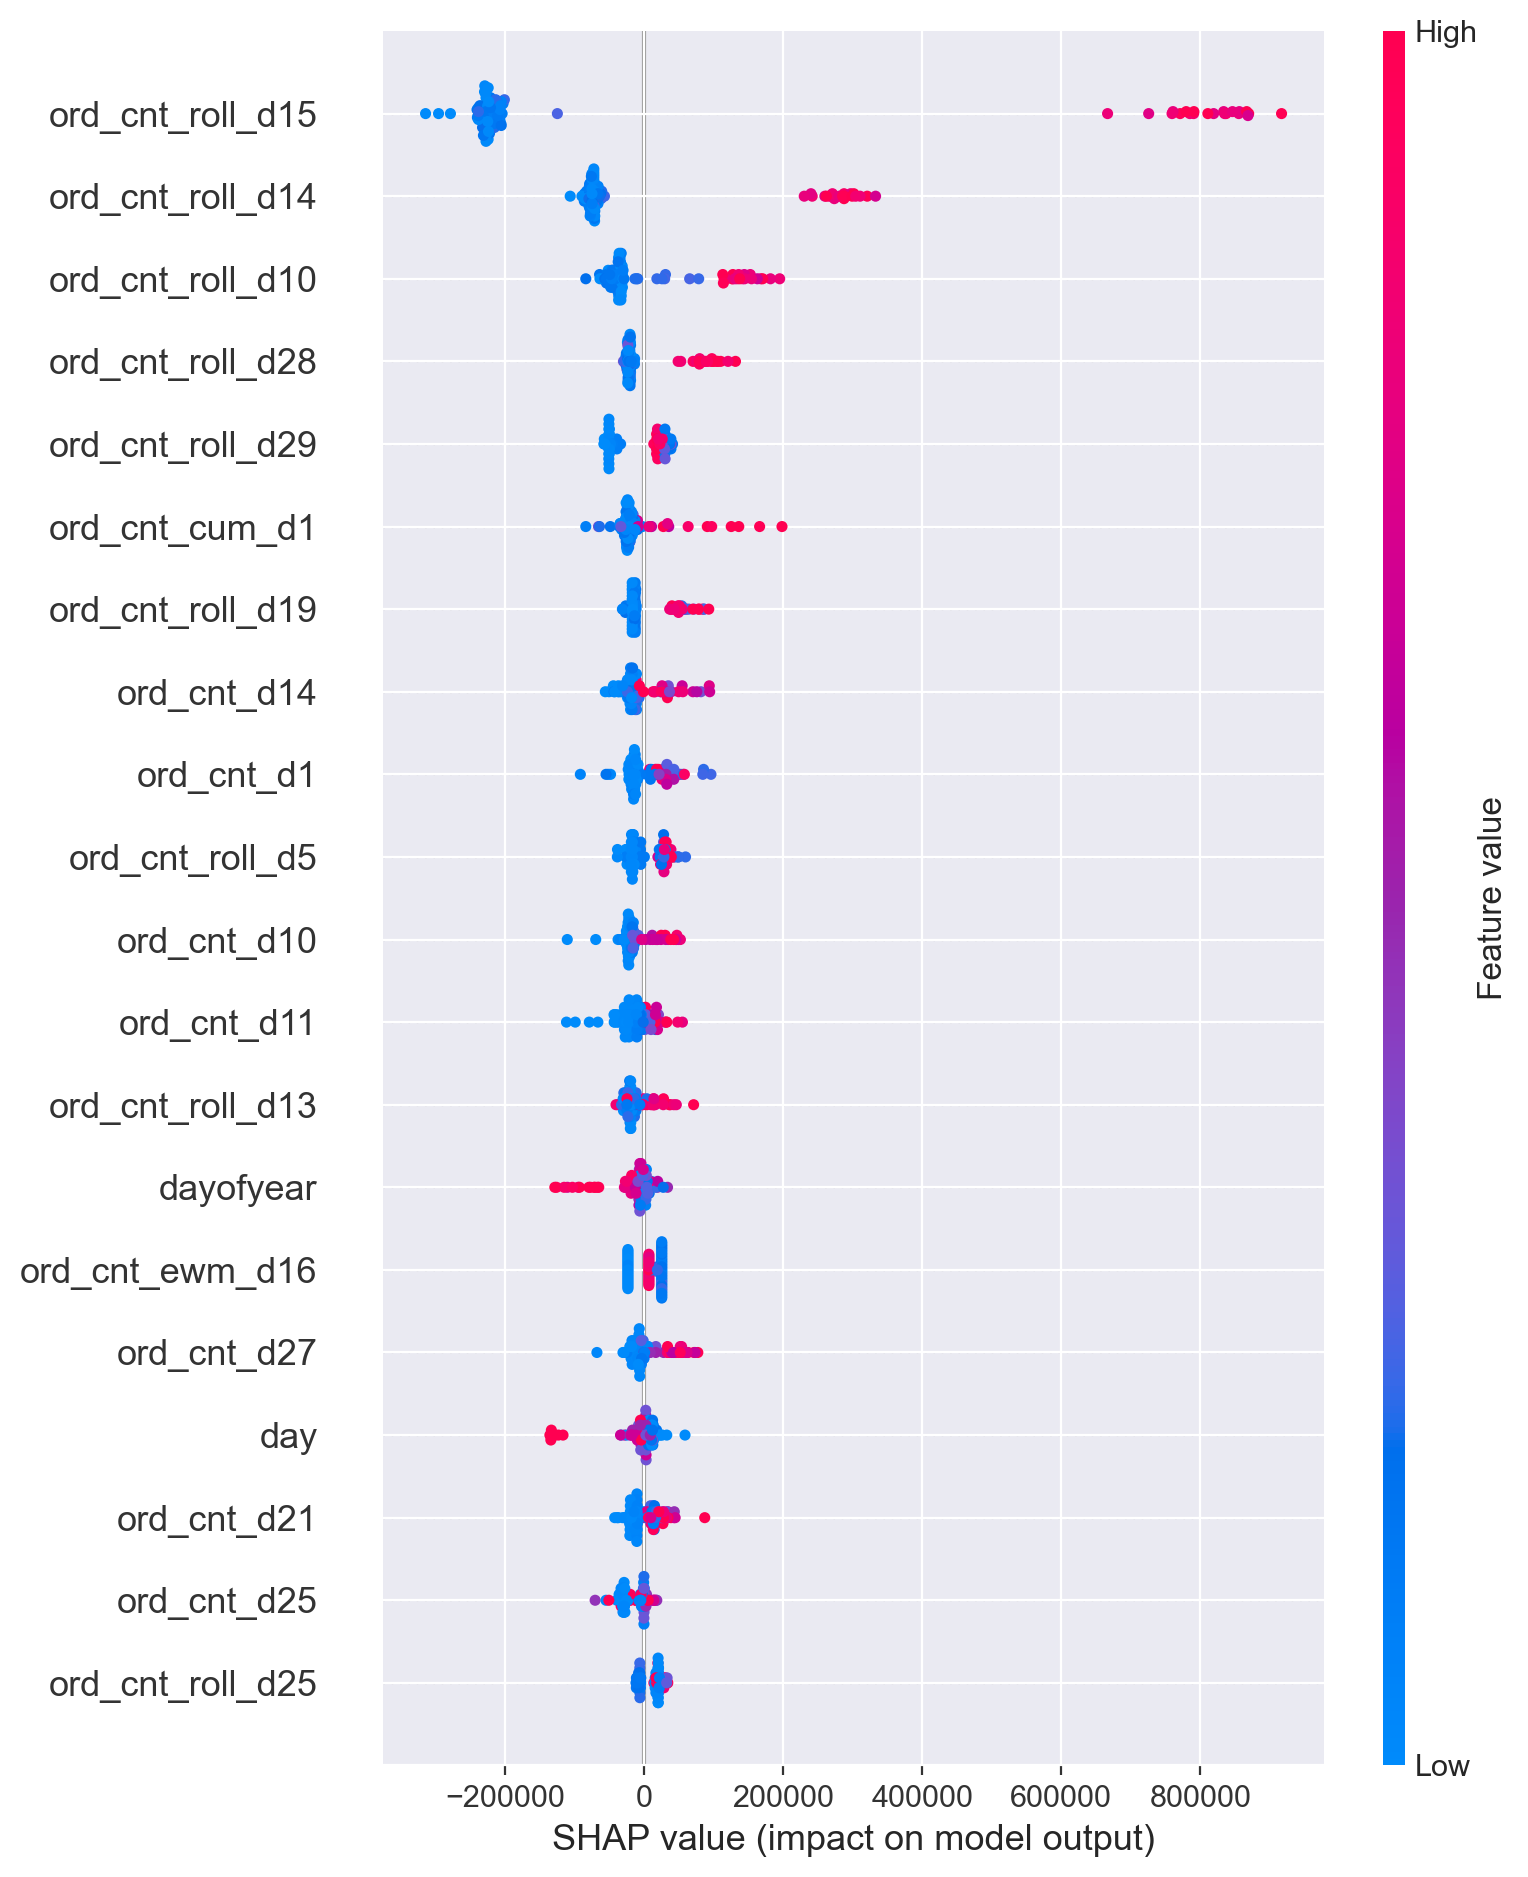

In [108]:
_check_feature_importance(df)

## Evalution of Prediction

In [117]:
pred_res.head()

,warehouse,order,pred_cnt,gap,ape
target_date,,,,,
2016-12-01,Whse_A,156324,118830,-37494,0.760152
2016-12-01,Whse_C,348018,335704,-12314,0.964617
2016-12-01,Whse_J,4957021,3436646,-1520375,0.693289
2016-12-01,Whse_S,770450,474314,-296136,0.615632
2016-12-02,Whse_A,56295,114515,58220,-0.034195


In [125]:
pred_res.groupby("warehouse").ape.median()

warehouse
Whse_A    0.711320
Whse_C    0.463893
Whse_J    0.794074
Whse_S    0.354929
Name: ape, dtype: float64

In [119]:
print(r2_score(pred_res['order'], pred_res['pred_cnt']))

0.7738107193637476


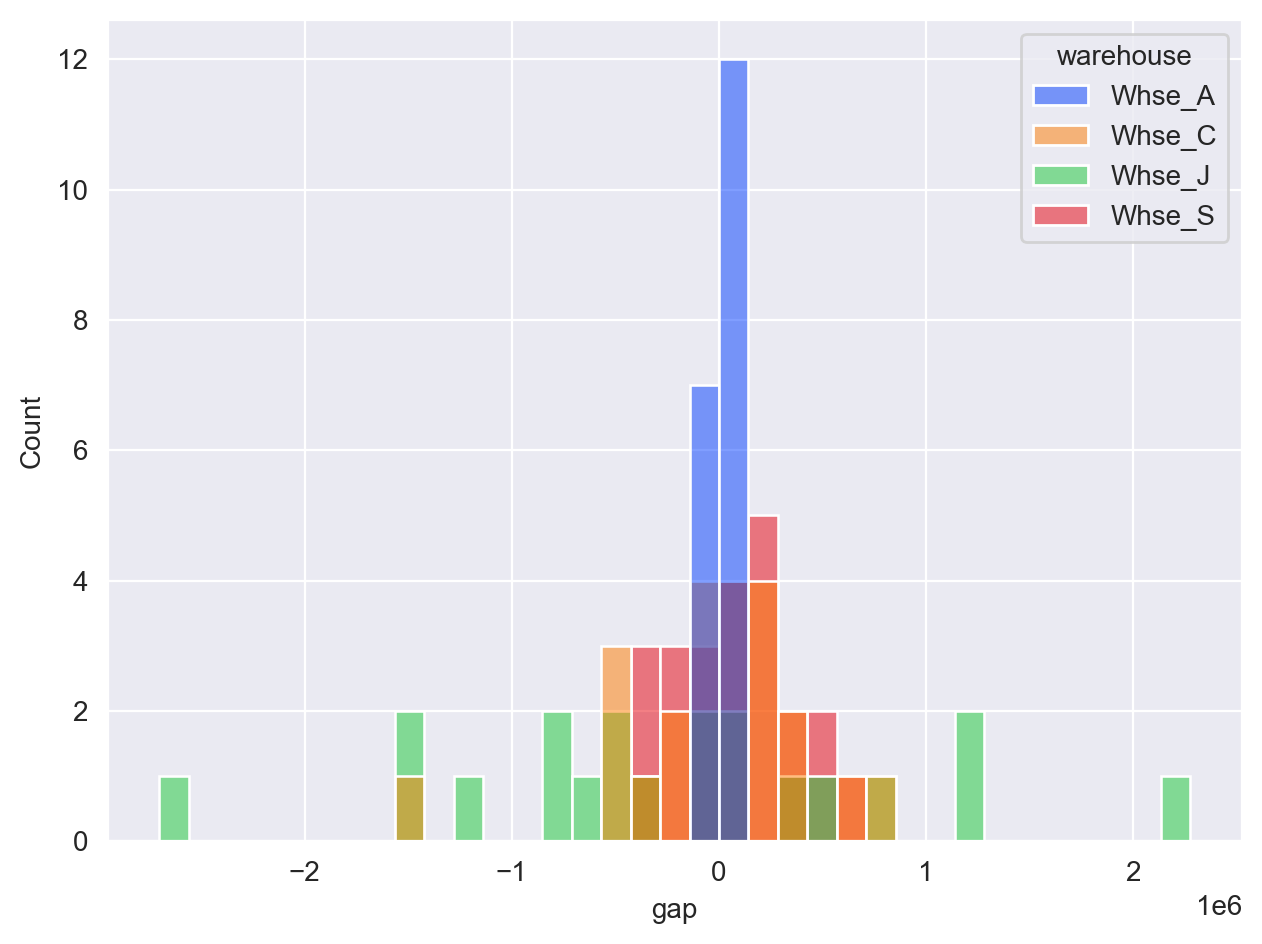

In [118]:
sns.histplot(x="gap", hue="warehouse", data=pred_res)
plt.tight_layout()

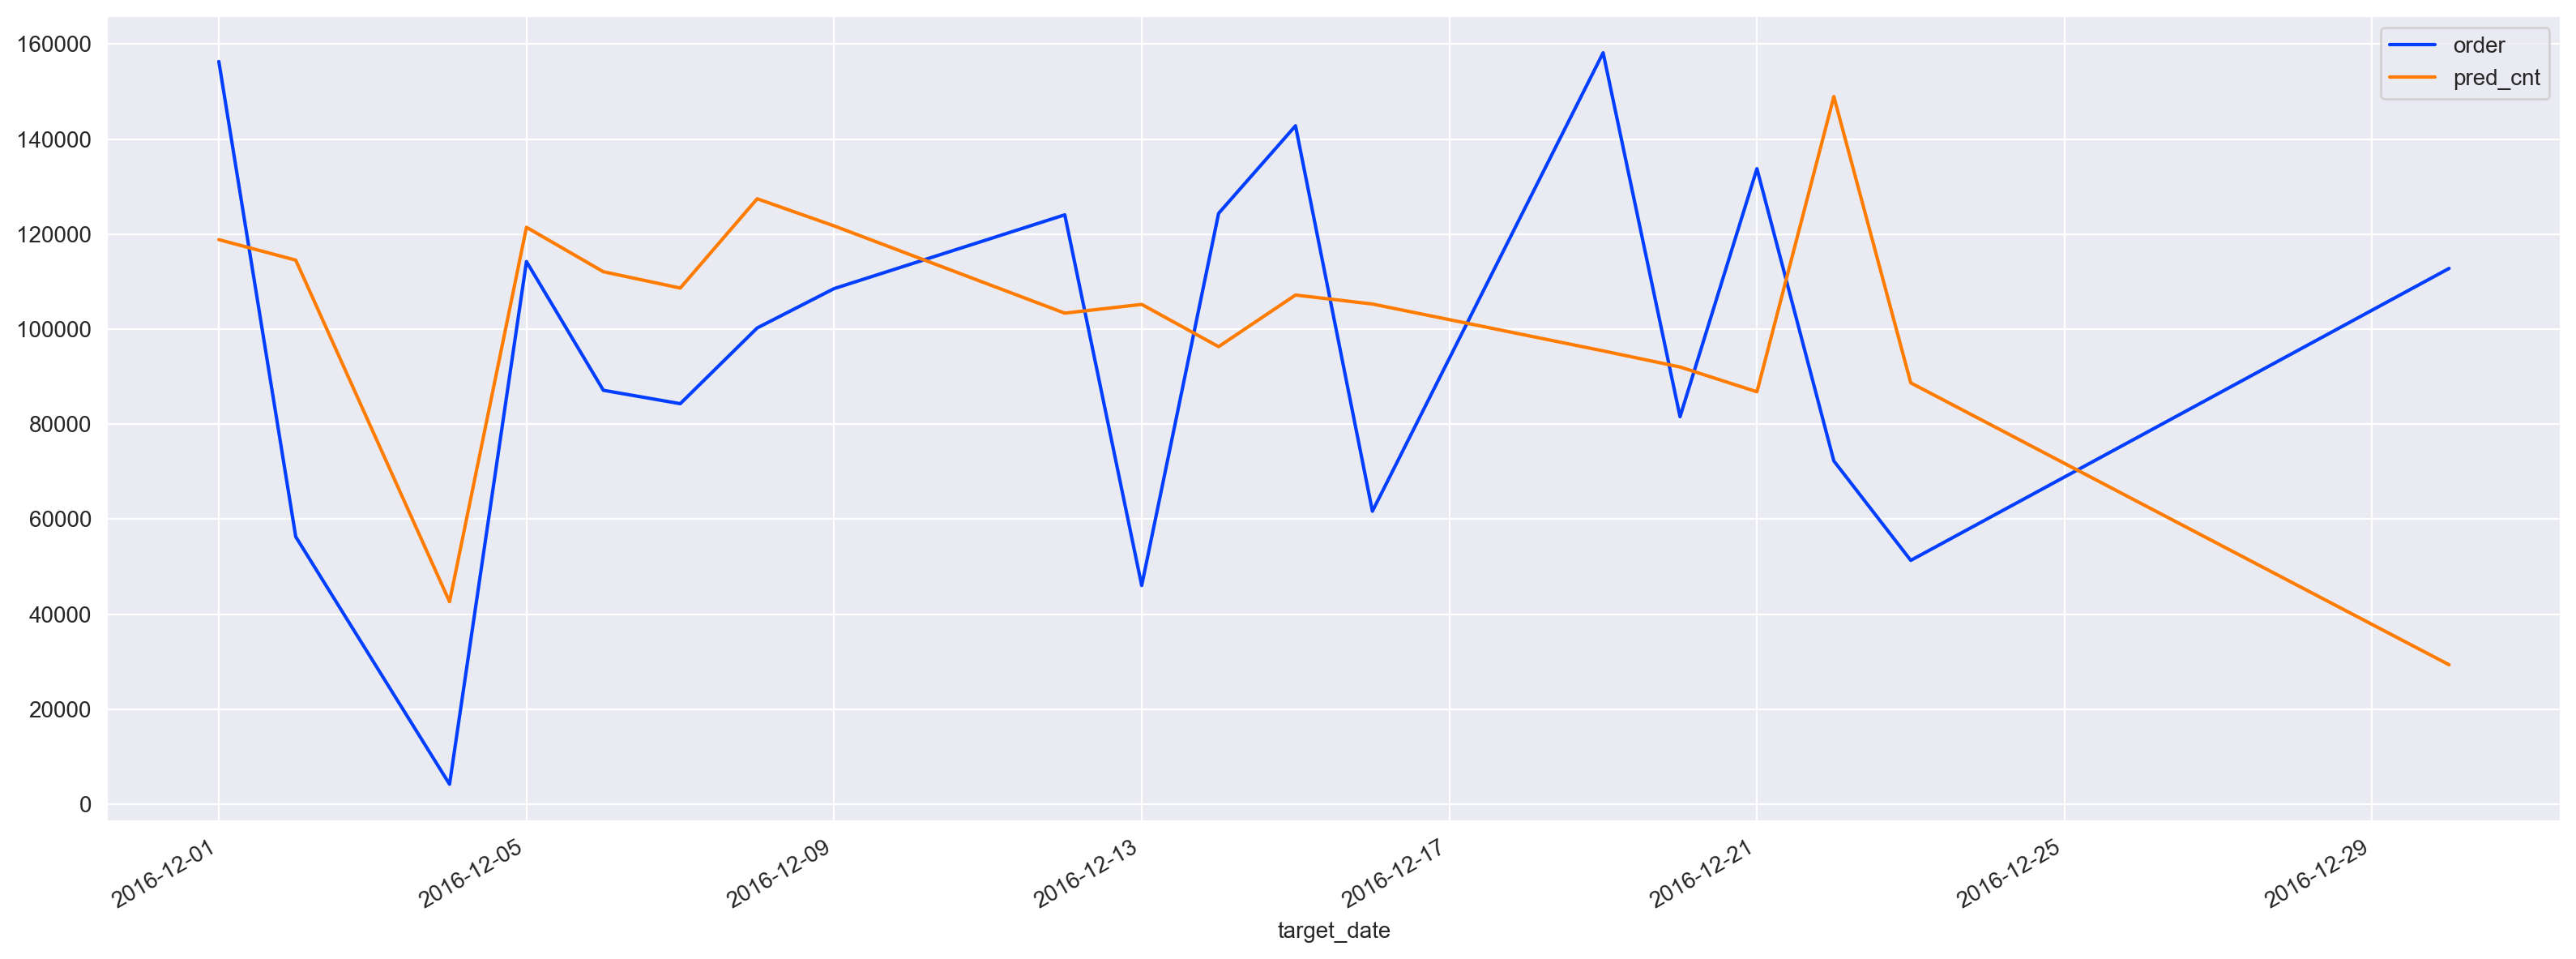

In [122]:
pred_res.query("warehouse == 'Whse_A'")[['order','pred_cnt']].plot(figsize=(16,6))
plt.tight_layout()

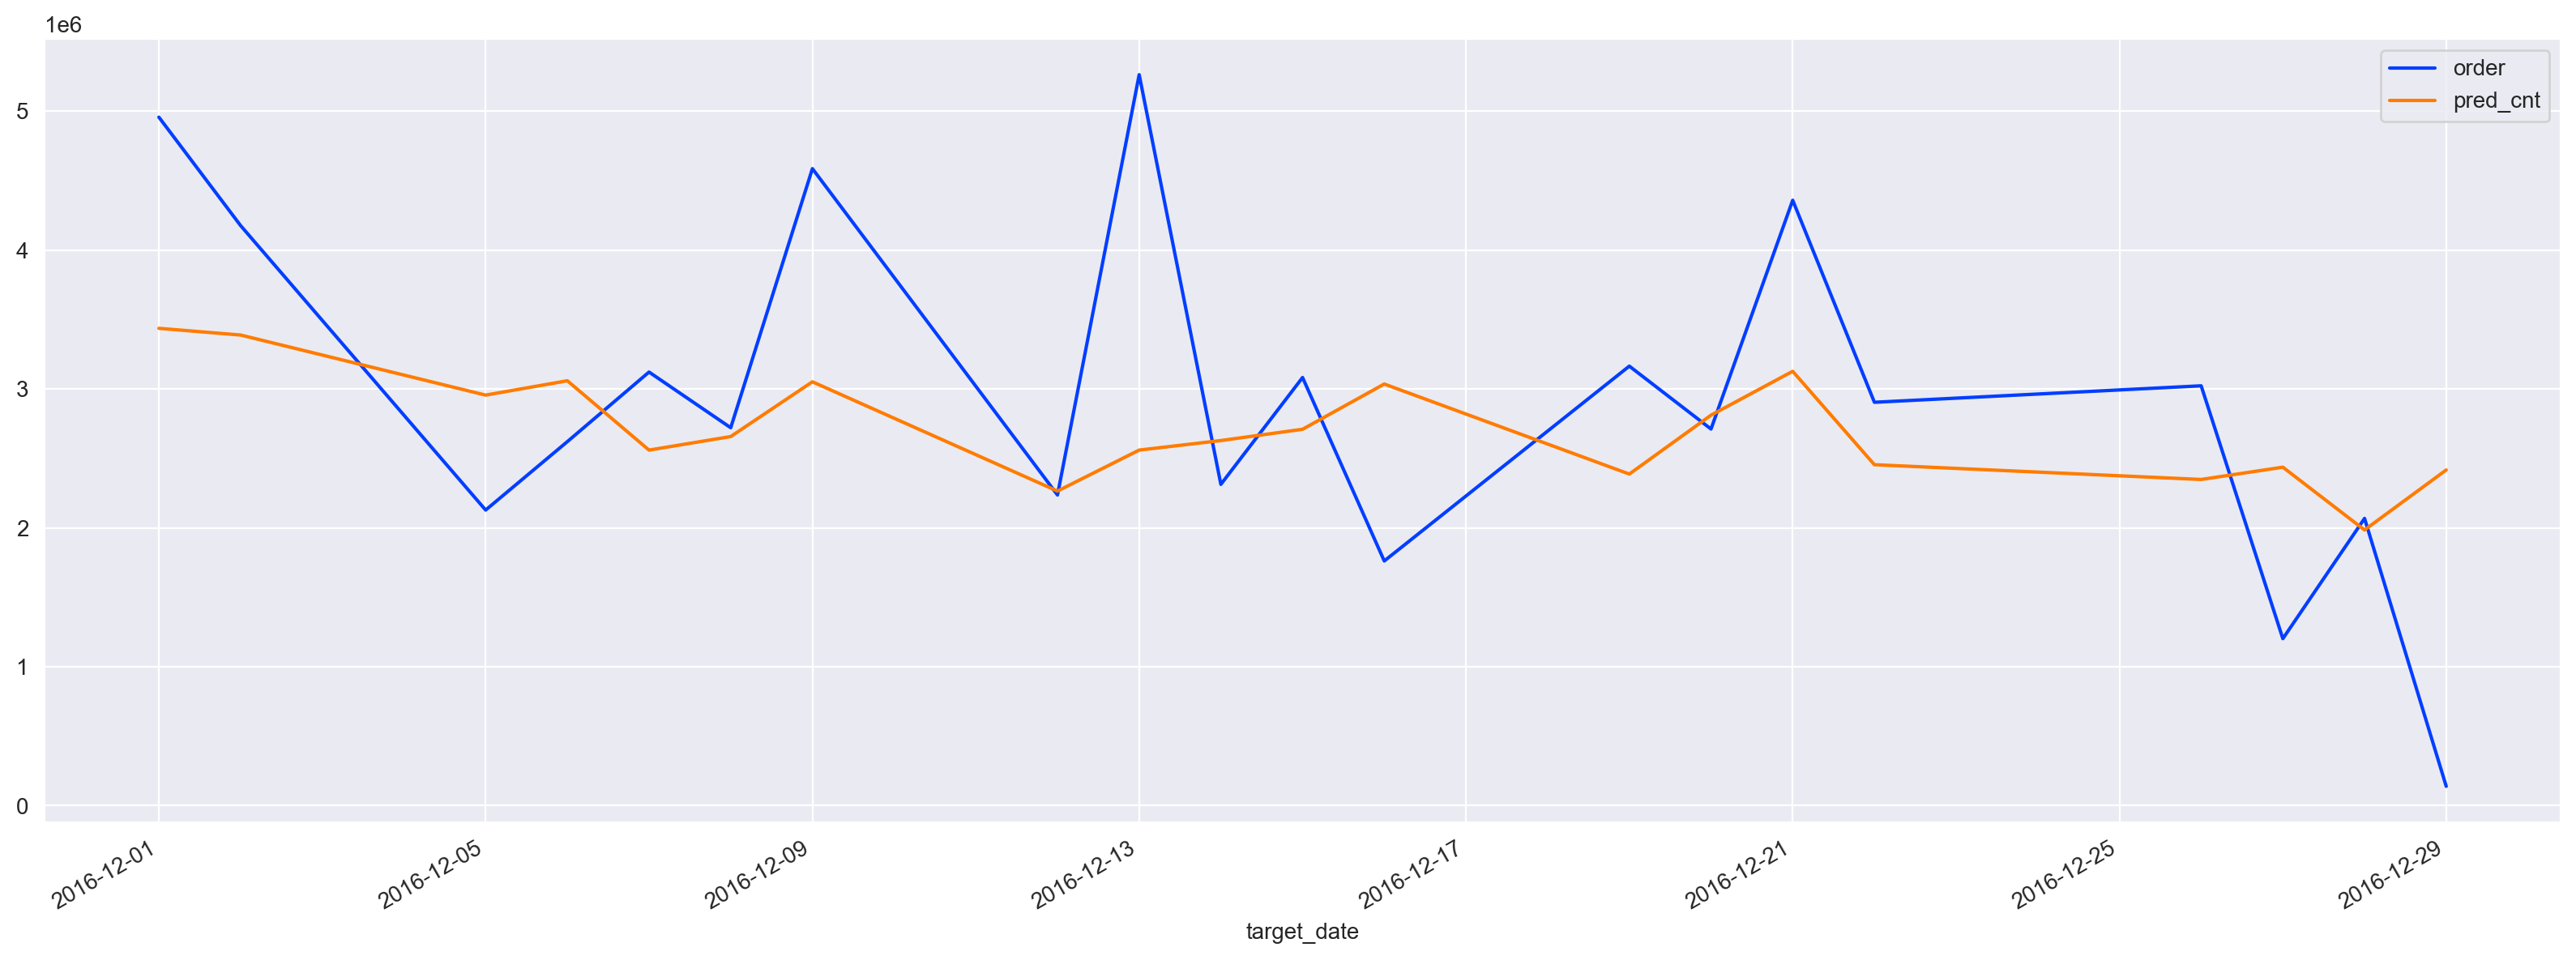

In [124]:
pred_res.query("warehouse == 'Whse_J'")[['order','pred_cnt']].plot(figsize=(16,6))
plt.tight_layout()